# Chapter 4. More Estimation

In [57]:
from my_suite import Pmf, Suite
import matplotlib.pyplot as plt
from statistics import median
from numpy import quantile

## The Euro problem

> When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110. ‘It looks very suspicious to me,’ said Barry Blight, a statistics lecturer at the London School of Economics. ‘If the coin were unbiased, the chance of getting a result as extreme as that would be less than 7%.'

We wanted to determine if the coin was biased rather than fair. To answer this, we proceeded in two steps:

1. Estimate the probability that the coin lands face up.
2. Evaluate whether the data supposrt the hypothesis that the coin is biased.

A coin has some probability $x$ of landing heads up when spun on edge dependent upon the physical properties of the coin, such as the distribution of mass. A balanced coin should have a probability of $x = 0.50$.

To use BT to estimate $x$, we defined 101 hypotheses such that x ranged from 0% to 100% with equal probability. This was our first prior. We then created a class `Euro` for this prior.

In [58]:
class Euro(Suite):
    '''
    A Suite for the Euro problem
    '''
    
    def Liklihood(self, data, hypo):
        x = hypo
        if data == 'H':
            return hypo/100.0
        else:
            return 1 - hypo/100.0

Then, we created the suite with the prior hypotheses with uniform liklihood.

In [59]:
suite = Euro(range(0, 101))
dataset = 'H' * 140 + 'T' * 110
for data in dataset:
    suite.Update(data)

Plotting the data showed that there was a curve focused just above 50%, as expected by the actual data.

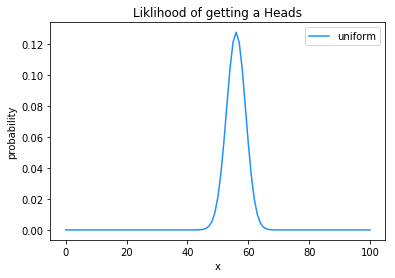

In [60]:
plt.plot(suite.hypotheses.values(), color = "dodgerblue", label = "uniform")
plt.ylabel("probability")
plt.xlabel("x")
plt.title('Liklihood of getting a Heads')
plt.legend()
plt.show()

## Summarizing the Posterior

One option is to calculate the maximum liklihood, the value with the highest posterior probability.

In [61]:
def MaximumLiklihood(pmf):
    '''
    Calculates the maximum liklihood of the posterior prob of a Suite object
    '''
    prob, val = max((prob, val) for val, prob in pmf.hypotheses.items())
    return val

In [62]:
MaximumLiklihood(suite)

56

It is no coincidence that this value is the same as the frequency of heads found in the data $140/200 = 56\%$. Thus, the observed percentage is the maximum liklihood.

Another option is to summarise the posterior by computing the mean and median.

In [63]:
def Mean(pmf):
    '''
    Calculates the mean of the posterior prob of a Suite object
    '''
    avg = sum(prob * val for val, prob in pmf.hypotheses.items())
    return avg


def Percentile(pmf, percentage):
    p = percentage / 100.0
    total = 0
    for val, prob in pmf.hypotheses.items():
        total += prob
        if total >= p:
            return val

In [64]:
print(Mean(suite))
print(Percentile(suite, 50))

55.95238095238095
56


Therefore, the credible interval can be calculates as a 90% interval from 5% to 95%.

In [65]:
# 5%
print(Percentile(suite, 5))
# 95%
print(Percentile(suite, 95))

51
61


Note that the credible interval does not include 50%, which suggests that the coin is not fair. However, the question requires a more precise answers as to what consitutes evidence for a hypotheses. This is discussed in the next chapter.

Before continuing, it is important to note that the posterior probability at 50% is meaningless because it depends on how many slices we divide out prior probability into.

## Swamping the priors

Swamping the priors is when, with enough data, different priors converge to the same posterior. In the book, Downey demonstrates how starting with a "triangular" prior with the center at 50% still leads to pretty much the same predictions based on maximum liklihood, mean, and median.

## Optimization

The current `Update()` method for `Suite` loops through all the data passed to it, then calls `Normalize()`, which again loops through the data. The new method `UpdateSet()` is more efficient.

In [66]:
def UpdateSet(self, dataset):
    for data in dataset:
        for hypo in self.hypotheses.values():
            like = self.Liklihood(data, hypo)
            self.Mult(hypo, like)
    return self.Normalize()

In [67]:
suite.UpdateSet(dataset)

`Liklihood` can also bee sped up to process the entire dataset rather than one new data point at a time.

In [68]:
class Euro(Suite):
    '''
    A Suite for the Euro problem
    '''
    
    def Liklihood(self, data, hypo):
        x = hypo / 100.0
        heads, tails = data
        like = x**heads * (1-x)**tails
        return like

In [69]:
heads, tails = 140, 110
suite.Update((heads, tails))

## The  beta distribution

Thus far we have used a discerete distribution for the values of $x$. Replacing this with a continuous distribution would further increase the efficiency of the `Euro` class. Here, we used a **beta distribution**.

The beta distribution is defined on the interval $[0,1]$. It also is a **conjugate prior**, that is, if the prior is a beta distribution, so will be the posterior. The shape of the beta distribution is defined by two paramters $\alpha$ and $\beta$. If the distribution has paramters $\alpha$ and $\beta$ and the data is $h$ heads and $t$ tails, then the parameters of the posterior  distribution will be $\alpha + h$ and $\beta + t$. Therefore, the update is completed via two additions.

For the euro problem, we defined the new prior as a beta distribution with $\alpha = 1$ and $\beta = 1$ which is a uniform distribution from $[0,1]$.

In [70]:
class Beta(object):
    '''
    A beta distribution for Bayes Thrm calculations
    '''
    def __init__(self, alpha=1, beta=1):
        self.alpha = alpha
        self.beta = beta
    
    
    # update the posterior distribution based on the number of 
    # Heads and Tails seen from the data
    def Update(self, data):
        heads, tails = data
        self.alpha += heads
        self.beta += tails
    
    
    # calculate the mean of the distribution
    def Mean(self):
        return float(self.alpha) / (self.alpha + self.beta)
    
    
    # evalute the PDF of the distribution
    def EvalPdf(self, x):
        return x**(self.alpha-1) * (1-x)**(self.beta-1)

In [71]:
beta = Beta()  # defaults to a uniform distribution
beta.Update((140, 110))  # update with data
print(beta.Mean())  # print the mean of the posterior

0.5595238095238095


(The `Beta` class was added to "my_beta.py". The `Pmf` class was updated with the new functions defined above.) 